# A notebook for exploring how best to measure the change in Mtb

In [1]:
import napari
from cellpose import models
from macrohet import dataio, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools, visualise

### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [4]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/19 03:38:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/19 03:38:53 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/19 03:38:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/19 03:38:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/19 03:38:53 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/19 03:38:54 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/19 03:38:54 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/19 03:38:54 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/19 03:39:11 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/19 03:39:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/19 03:39:11 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:39:11 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:39:11 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/19 03:39:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/19 03:39:12 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/19 03:39:12 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:39:12 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:39:12 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/19 03:39:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/19 03:39:14 PM] Opening HDF file: /mnt/DATA/macrohe

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [5]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl')
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


### Renaming delta Mtb method of choice for ease of use

In [6]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

### Adding technical replicate label 

In [129]:
df['Technical replicate'] = df['Acquisition ID'].apply(lambda x: 1 if x[0] in [3, 5] else 2)

# Style

In [8]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [9]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [43]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

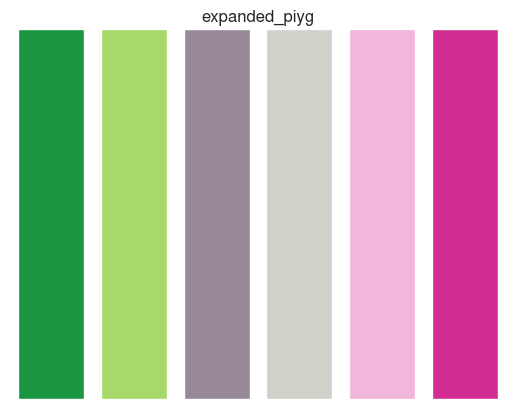

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [44]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [11]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/'
os.makedirs(output_dir, exist_ok = True)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [130]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232,1
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112,1
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000,1
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032,2
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153,2
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089,2
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167,2


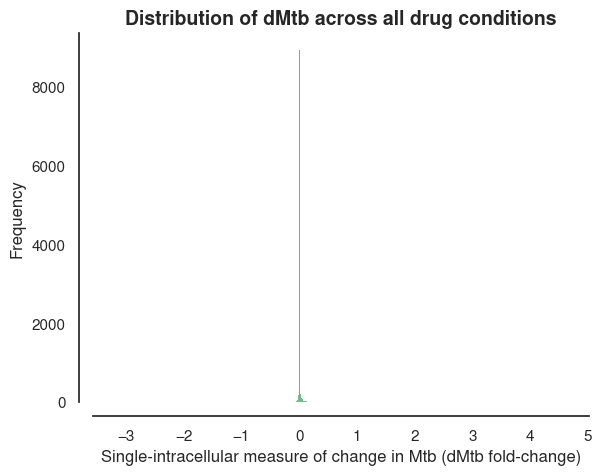

In [13]:

sns.histplot(data=df_delta_mtb, x='dMtb', kde=False, bins = 400, color=expanded_piyg[0])
sns.despine(offset=10)
# plt.ylim(0,2000)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
#            bbox_inches = 'tight', dpi = 314)
plt.ylabel('Frequency')
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_conditions.png', 
#            bbox_inches = 'tight', dpi = 314)
plt.show() 

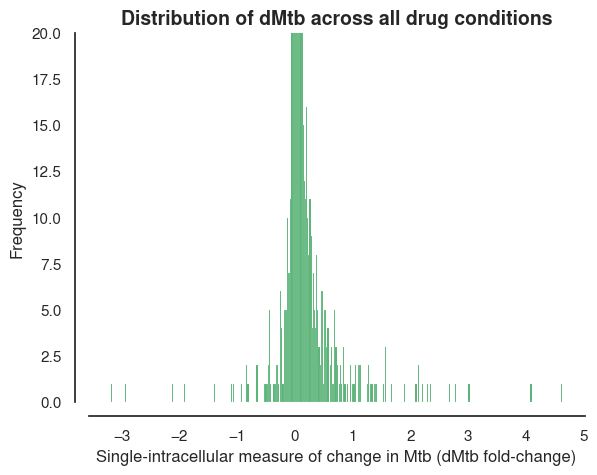

In [14]:
sns.histplot(data=df_delta_mtb, x='dMtb', kde=False, bins = 400, color=expanded_piyg[0])
sns.despine(offset=10)
plt.ylim(0,20)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
#            bbox_inches = 'tight', dpi = 314)
plt.ylabel('Frequency')
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_conditions_clipped.png', 
#            bbox_inches = 'tight', dpi = 314)
plt.show() 

In [131]:
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232,1
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112,1
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000,1
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032,2
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153,2
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089,2
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167,2


In [132]:
# "Melt" the DataFrame to "long-form" or "tidy" representation
df_melted = pd.melt(df_delta_mtb, ["Compound", "Concentration"], var_name="measurement")
df_melted = df_melted[df_melted['measurement'] == 'dMtb']
# Rename the 'value' column to 'dMtb'
df_melted = df_melted.rename(columns={'value': 'dMtb'})

df_melted

,Compound,Concentration,measurement,dMtb
260728,CTRL,EC0,dMtb,0.095232
260729,CTRL,EC0,dMtb,-0.000112
260730,CTRL,EC0,dMtb,0.0
260731,CTRL,EC0,dMtb,0.000586
260732,CTRL,EC0,dMtb,0.000544
...,...,...,...,...
270751,BDQ,EC99,dMtb,0.000032
270752,BDQ,EC99,dMtb,-0.000153
270753,BDQ,EC99,dMtb,0.000089
270754,BDQ,EC99,dMtb,0.000167


In [108]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
from bokeh.models import Label
from bokeh.models import LogScale
from bokeh.models import NumeralTickFormatter

output_notebook()


Loading BokehJS ...

In [49]:
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.418707,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,-0.142246,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.000000,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.346945,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.031179,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,-0.000397,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.050624,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.366863,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.374870,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167


In [133]:
df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'})


,Strain,Compound,Concentration,count
0,RD1,CTRL,EC0,1344
1,WT,BDQ,EC50,908
2,WT,BDQ,EC99,684
3,WT,CTRL,EC0,1934
4,WT,INH,EC50,842
5,WT,INH,EC99,817
6,WT,PZA,EC50,918
7,WT,PZA,EC99,901
8,WT,RIF,EC50,817
9,WT,RIF,EC99,863


In [176]:
expanded_piyg_dict = {
                      'CTRL':expanded_piyg[0], 
                      'RD1':expanded_piyg[-1],
                      'BDQ':expanded_piyg[0], 
                      'INH':expanded_piyg[1], 
                      'PZA':expanded_piyg[4], 
                      'RIF':expanded_piyg[5]}

In [154]:
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232,1
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112,1
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000,1
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032,2
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153,2
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089,2
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167,2


In [288]:
for index, row_ in df_delta_mtb.iterrows():
    cell_ID = row_['Cell ID']
    row, column = row_['Acquisition ID']
    online_fn = f'https://macrohet.s3.eu-west-2.amazonaws.com/{row},{column}/glimpse_{cell_ID}.{row}.{column}_t0.png'
    df_delta_mtb.at[index, 'glimpse_url'] = online_fn


# Creating scatter from one data source

Cannot currently link image URLs to segregated datasources...

In [ ]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import column
from bokeh.layouts import gridplot

output_notebook()

In [635]:
outlier_df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url
90597,0,990.390564,251.635727,4991.568442,1268.244064,1.0,1.0,1.0,48818.0,523.048645,...,0.0,WT,RIF,EC50,338,"(3, 7)",338.3.7,-0.133241,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
94861,0,852.202881,624.776123,4295.102520,3148.871660,1.0,1.0,1.0,16546.0,563.117798,...,0.0,WT,RIF,EC50,525,"(3, 7)",525.3.7,-0.082176,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
97336,0,702.944031,1138.155518,3542.837915,5736.303809,1.0,1.0,1.0,30848.0,528.072083,...,0.0,WT,RIF,EC50,160,"(3, 7)",160.3.7,-0.344935,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
99680,0,1081.588867,903.161987,5451.207891,4551.936416,1.0,1.0,1.0,13003.0,527.924194,...,0.0,WT,RIF,EC50,43,"(3, 7)",43.3.7,0.061996,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
101552,0,867.750305,1033.468994,4373.461538,5208.683730,0.0,0.0,1.0,32615.0,371.332214,...,0.0,WT,RIF,EC50,305,"(3, 7)",305.3.7,0.691282,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
103221,0,1078.560425,1139.710327,5435.944541,5744.140049,0.0,0.0,1.0,19498.0,365.487946,...,0.0,WT,RIF,EC50,176,"(3, 7)",176.3.7,0.089430,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
103266,0,241.929916,1146.574219,1219.326779,5778.734062,0.0,0.0,1.0,70491.0,372.541199,...,0.0,WT,RIF,EC50,178,"(3, 7)",178.3.7,0.072925,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
105468,1,192.037262,1119.970215,967.867800,5644.649883,1.0,1.0,1.0,22540.0,386.260651,...,0.0,WT,RIF,EC50,663,"(3, 7)",663.3.7,0.131769,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
105709,2,560.839600,7.946970,2826.631582,40.052726,1.0,1.0,1.0,6695.0,376.501404,...,0.0,WT,RIF,EC50,823,"(3, 7)",823.3.7,0.058769,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
107183,3,159.784592,967.987671,805.314342,4878.657861,1.0,1.0,0.0,26761.0,374.678711,...,0.0,WT,RIF,EC50,905,"(3, 7)",905.3.7,-0.253604,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...


In [693]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the upper plot
p1 = figure(height=600, 
            width=600, 
            title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
            y_axis_type="log",
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-1, 1)

# Customize y-axis ticker
p1.yaxis.ticker = [1, 10, 100, 1000]  # Set specific tick values
p1.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=600, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)

p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
"""



)

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
                             & (df_delta_mtb['Technical replicate'] == 1)]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    hist, edges = np.histogram(data, bins=16)  # Change the number of bins as needed
    source = ColumnDataSource(data=dict(hist=hist, 
                                        left=edges[:-1], 
                                        right=edges[1:], 
                                        center=(edges[:-1]+edges[1:])/2))
    
    # Create a quad glyph for the histogram in the upper plot
    p1.quad(top='hist', bottom=0.9, left='left', right='right',
            line_color='black', source=source, 
            fill_color=expanded_piyg_dict[compound], 
            line_width=2, 
            alpha=0.9,
            muted_color=expanded_piyg_dict[compound], 
            muted_alpha=0.1,
            legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df.index/5E5,
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
#               legend_label=col_source_dict[index].name, 
              source=source,
              color=expanded_piyg_dict[compound], 
              alpha=0.9, 
              size=20,
              line_color='black',  # Set the color of the outline
              line_width=1,  # Set the width of the outline
              muted_color=expanded_piyg_dict[compound], 
              muted_alpha=0.1,
               )

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots
p = gridplot([[p1], [p2]],)

output_file("dMtb_hist_ec50.html",)# title="dMtb")

show(p)


# KDE hist

In [694]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde
from bokeh.models import Range1d

# Create the upper plot
p1 = figure(height=400, 
            width=1000, 
            title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
#             y_axis_type="log",
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.5,0.5)

# Customize y-axis ticker
# p1.yaxis.ticker = [1, 10, 100, 1000]  # Set specific tick values
# p1.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=1000, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)
p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
"""



)

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
                             & (df_delta_mtb['Technical replicate'] == 1)]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

#     # Create a quad glyph for the histogram in the upper plot
#     p1.quad(top='kde_values', bottom=0, left='x', right='x',
#             line_color='black', source=source, 
#             fill_color=expanded_piyg_dict[compound], 
#             line_width=2, 
#             alpha=0.9,
#             muted_color=expanded_piyg_dict[compound], 
#             muted_alpha=0.1,
#             legend_label=label)
    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x = 'x', y1 = 0, y2 = 'kde_values',
#             line_color='black', 
            source=source, 
#             line_color=expanded_piyg_dict[compound], 
            fill_color=expanded_piyg_dict[compound], 
#             line_width=2, 
            alpha=0.6,
            muted_color=expanded_piyg_dict[compound], 
            muted_alpha=0.1,
            legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df.index/5E5,
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
#               legend_label=col_source_dict[index].name, 
              source=source,
              color=expanded_piyg_dict[compound], 
              alpha=0.9, 
              size=20,
              line_color='black',  # Set the color of the outline
              line_width=1,  # Set the width of the outline
              muted_color=expanded_piyg_dict[compound], 
              muted_alpha=0.1,
               )

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots
p = gridplot([[p1], [p2]],)

output_file("dMtb_kde_ec50.html",)# title="dMtb")

show(p)


In [726]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the upper plot
p1 = figure(height=400, 
            width=500, 
            title='Histograms showing the distribution of \nthe change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.4, 0.4)
# Customize y-axis ticker
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=500, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)

p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
""")

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p1.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3, 
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df.index/5E5,
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p3 = figure(height=400, 
            width=500, 
#             title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p3.toolbar.active_scroll = p3.select_one(WheelZoomTool)
p3.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p3.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p4 = figure(height=200, 
            width=500, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p3.x_range)

p4.yaxis.ticker = []  # Remove y-axis ticks
p4.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p4.toolbar.active_scroll = p4.select_one(WheelZoomTool)

p4.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)


for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC99':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p3.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p3.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3,
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df.index/5E5,
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p4.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )

# Set the legend location for the upper plot
p3.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p3.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p5 = figure(height=400, 
            width=500, 
            title='Control experiments', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p5.toolbar.active_scroll = p5.select_one(WheelZoomTool)
p5.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p5.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p6 = figure(height=200, 
            width=500, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p5.x_range)

p6.yaxis.ticker = []  # Remove y-axis ticks
p6.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p6.toolbar.active_scroll = p6.select_one(WheelZoomTool)

p6.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)

for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC0':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p5.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p5.line(x='x', y='kde_values',
             source=source, 
             line_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1], 
             line_width = 1,
             line_dash = 'dashed',
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df.index/5E5,
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p6.scatter('x', 'y', 
               source=source,
               fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )

# Set the legend location for the upper plot
p5.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p5.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots repeated on the right-hand side
p = gridplot([[p1, p3, p5], [p2, p4, p6]])

output_file("dMtb_kde.html",title="dMtb")

show(p)


# Adding images


In [727]:
outliers = pd.concat(outliers, ignore_index=True)
outliers

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url,glimpse_url_t0,glimpse_url_tn
0,0,539.885864,99.211456,2721.024756,500.025740,0.0,0.0,1.0,24629.0,367.672302,...,BDQ,EC50,421,"(3, 9)",421.3.9,0.244142,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
1,0,1074.527832,811.853455,5415.620273,4091.741411,0.0,0.0,1.0,19622.0,369.415039,...,BDQ,EC50,113,"(3, 9)",113.3.9,1.114547,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
2,0,1097.321167,847.022522,5530.498682,4268.993511,0.0,0.0,1.0,10637.0,375.349060,...,BDQ,EC50,26,"(3, 9)",26.3.9,0.254726,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
3,0,1039.033447,916.104431,5236.728574,4617.166333,1.0,1.0,1.0,19872.0,389.052826,...,BDQ,EC50,63,"(3, 9)",63.3.9,0.154472,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
4,0,771.073486,1052.282593,3886.210371,5303.504268,0.0,0.0,1.0,28811.0,361.714722,...,BDQ,EC50,275,"(3, 9)",275.3.9,0.160494,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,4,757.554932,170.470444,3818.076855,859.171036,1.0,1.0,1.0,13940.0,388.782074,...,CTRL,EC0,1075,"(6, 5)",1075.6.5,0.276201,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
311,6,122.582176,206.176346,617.814168,1039.128783,0.0,0.0,1.0,14622.0,382.337433,...,CTRL,EC0,1216,"(6, 5)",1216.6.5,0.258478,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
312,7,818.922974,438.001740,4127.371787,2207.528767,0.0,0.0,1.0,31789.0,345.671936,...,CTRL,EC0,1314,"(6, 5)",1314.6.5,1.900590,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
313,16,333.640533,118.059662,1681.548289,595.020696,0.0,0.0,1.0,52010.0,366.959137,...,CTRL,EC0,1894,"(6, 5)",1894.6.5,1.283940,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...


In [730]:
from macrohet import aws_tools

In [ ]:
/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_2492.3.5_t34.png,
/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_2416.3.6_t26.png,
/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_2160.3.7_t23.png,
/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_1274.4.9_t9.png,
/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_725.4.5_t-1.png,
/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_557.4.4_t-1.png,

In [753]:
for index, row_ in tqdm(outliers.iterrows(), total = len(outliers)):
    unique_ID = row_['Unique ID']
    cell_ID, row, column = unique_ID.split('.') 
    t0 = row_['Time (hours)']
    time = [t0, -1]
    for t in time:
        output_fn = f'/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_{cell_ID}.{row}.{column}_t{t}.png'
        if os.path.exists(output_fn):
            continue
        glimpse = tn_glimpse_maker(unique_ID, df, time=t)
        imsave(output_fn, glimpse)
        basename = os.path.basename(output_fn)
        aws_fn = f'dMtb/dMtb_glimpses/{basename}'
        aws_tools.upload(output_fn, 
                         'macrohet', 
                            aws_fn,)

  0%|          | 0/315 [00:00<?, ?it/s]

[INFO][2023/06/21 03:59:04 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/21 03:59:25 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 03:59:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5


dMtb/dMtb_glimpses/glimpse_1043.6.7_t-1.png: Upload Successful


[INFO][2023/06/21 03:59:45 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/21 04:00:01 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:00:01 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5


dMtb/dMtb_glimpses/glimpse_1033.6.7_t4.png: Upload Successful


[INFO][2023/06/21 04:00:18 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/21 04:00:32 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:00:32 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5


dMtb/dMtb_glimpses/glimpse_1033.6.7_t-1.png: Upload Successful


[INFO][2023/06/21 04:00:48 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/21 04:01:00 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:01:00 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5


dMtb/dMtb_glimpses/glimpse_1417.6.7_t10.png: Upload Successful


[INFO][2023/06/21 04:01:20 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/21 04:01:29 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:01:29 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5


dMtb/dMtb_glimpses/glimpse_1417.6.7_t-1.png: Upload Successful


[INFO][2023/06/21 04:01:49 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:01:58 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:01:58 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_355.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:02:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:02:26 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:02:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_355.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:02:46 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:02:55 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:02:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_609.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:03:16 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:03:25 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:03:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_609.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:03:45 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:03:54 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:03:54 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_640.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:04:19 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:04:28 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:04:28 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_640.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:04:56 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:05:05 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:05:05 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_557.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:05:24 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:05:33 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:05:33 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_557.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:05:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:06:02 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:06:02 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_288.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:06:18 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:06:28 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:06:28 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_288.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:06:44 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:06:53 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:06:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_320.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:07:09 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:07:19 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:07:19 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_320.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:07:35 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:07:44 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:07:44 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_304.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:08:03 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:08:12 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:08:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_304.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:08:32 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:08:40 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:08:40 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_167.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:09:00 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:09:08 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:09:08 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_167.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:09:28 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:09:36 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:09:36 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_182.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:09:52 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:10:01 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:10:01 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_182.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:10:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:10:26 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:10:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_208.4.4_t0.png: Upload Successful


[INFO][2023/06/21 04:10:42 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:10:51 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:10:51 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_208.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:11:07 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:11:16 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:11:16 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_670.4.4_t1.png: Upload Successful


[INFO][2023/06/21 04:11:31 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:11:40 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:11:40 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_670.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:11:56 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:12:05 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:12:05 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_1472.4.4_t12.png: Upload Successful


[INFO][2023/06/21 04:12:21 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:12:29 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:12:29 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_1472.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:12:49 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:12:58 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:12:58 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_2039.4.4_t22.png: Upload Successful


[INFO][2023/06/21 04:13:18 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:13:26 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:13:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_2039.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:13:46 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:13:55 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:13:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_2326.4.4_t27.png: Upload Successful


[INFO][2023/06/21 04:14:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:14:22 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:14:22 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_2326.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:14:44 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:14:53 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:14:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_2502.4.4_t30.png: Upload Successful


[INFO][2023/06/21 04:15:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2023/06/21 04:15:25 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:15:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 4).h5


dMtb/dMtb_glimpses/glimpse_2502.4.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:15:49 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:15:59 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:15:59 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_501.6.4_t0.png: Upload Successful


[INFO][2023/06/21 04:16:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:16:23 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:16:23 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_501.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:16:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:16:47 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:16:47 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_655.6.4_t0.png: Upload Successful


[INFO][2023/06/21 04:17:07 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:17:15 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:17:15 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_655.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:17:35 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:17:44 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:17:44 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_546.6.4_t0.png: Upload Successful


[INFO][2023/06/21 04:18:08 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:18:16 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:18:16 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_546.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:18:41 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:18:49 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:18:49 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_553.6.4_t0.png: Upload Successful


[INFO][2023/06/21 04:19:09 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:19:17 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:19:17 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_553.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:19:37 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:19:46 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:19:46 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_592.6.4_t0.png: Upload Successful


[INFO][2023/06/21 04:20:05 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:20:14 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:20:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_592.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:20:33 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:20:41 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:20:41 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_300.6.4_t0.png: Upload Successful


[INFO][2023/06/21 04:21:01 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:21:10 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:21:10 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_300.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:21:29 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:21:38 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:21:38 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1015.6.4_t4.png: Upload Successful


[INFO][2023/06/21 04:22:03 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:22:11 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:22:11 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1015.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:22:36 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:22:45 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:22:45 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1418.6.4_t9.png: Upload Successful


[INFO][2023/06/21 04:23:04 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:23:13 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:23:13 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1418.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:23:32 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:23:41 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:23:41 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1923.6.4_t17.png: Upload Successful


[INFO][2023/06/21 04:24:05 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:24:13 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:24:13 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1923.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:24:38 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:24:47 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:24:47 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1983.6.4_t18.png: Upload Successful


[INFO][2023/06/21 04:25:06 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:25:15 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:25:15 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_1983.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:25:31 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:25:40 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:25:40 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_2758.6.4_t31.png: Upload Successful


[INFO][2023/06/21 04:26:00 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2023/06/21 04:26:08 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:26:08 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 4).h5


dMtb/dMtb_glimpses/glimpse_2758.6.4_t-1.png: Upload Successful


[INFO][2023/06/21 04:26:28 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:26:37 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:26:37 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_360.3.5_t0.png: Upload Successful


[INFO][2023/06/21 04:26:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:27:02 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:27:02 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_360.3.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:27:22 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:27:31 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:27:31 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_486.3.5_t0.png: Upload Successful


[INFO][2023/06/21 04:27:50 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:28:00 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:28:00 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_486.3.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:28:19 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:28:28 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:28:28 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_223.3.5_t0.png: Upload Successful


[INFO][2023/06/21 04:28:47 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:28:57 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:28:57 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_223.3.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:29:16 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:29:25 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:29:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_638.3.5_t1.png: Upload Successful


[INFO][2023/06/21 04:29:40 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:29:49 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:29:49 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_638.3.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:30:05 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:30:14 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:30:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_1324.3.5_t11.png: Upload Successful


[INFO][2023/06/21 04:30:34 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:30:42 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:30:42 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_1324.3.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:31:08 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:31:17 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:31:17 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_2492.3.5_t34.png: Upload Successful


[INFO][2023/06/21 04:31:33 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/21 04:31:42 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:31:42 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


dMtb/dMtb_glimpses/glimpse_2492.3.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:31:58 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:32:07 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:32:07 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_639.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:32:27 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:32:37 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:32:37 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_639.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:32:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:33:02 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:33:02 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_621.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:33:22 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:33:30 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:33:30 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_621.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:33:50 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:33:59 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:33:59 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_530.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:34:18 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:34:26 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:34:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_530.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:34:49 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:34:58 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:34:58 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_510.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:35:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:35:26 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:35:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_510.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:35:46 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:35:55 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:35:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_150.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:36:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:36:22 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:36:22 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_150.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:36:42 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:36:50 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:36:50 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_162.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:37:10 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:37:19 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:37:19 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_162.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:37:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:37:48 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:37:48 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_11.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:38:04 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:38:14 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:38:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_11.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:38:30 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:38:39 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:38:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_44.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:38:55 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:39:04 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:39:04 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_44.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:39:19 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:39:30 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:39:30 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_184.4.5_t0.png: Upload Successful


[INFO][2023/06/21 04:39:46 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:39:58 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:39:58 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_184.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:40:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:40:24 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:40:24 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_725.4.5_t1.png: Upload Successful


[INFO][2023/06/21 04:40:40 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:40:49 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:40:49 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_725.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:41:05 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:41:14 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:41:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_727.4.5_t1.png: Upload Successful


[INFO][2023/06/21 04:41:30 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:41:39 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:41:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_727.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:41:55 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:42:03 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:42:03 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_698.4.5_t1.png: Upload Successful


[INFO][2023/06/21 04:42:19 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:42:28 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:42:28 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_698.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:42:44 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:42:53 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:42:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_835.4.5_t2.png: Upload Successful


[INFO][2023/06/21 04:43:09 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:43:17 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:43:17 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_835.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:43:33 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:43:42 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:43:42 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_840.4.5_t2.png: Upload Successful


[INFO][2023/06/21 04:43:57 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:44:07 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:44:07 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_840.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:44:26 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:44:34 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:44:34 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_873.4.5_t2.png: Upload Successful


[INFO][2023/06/21 04:44:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:45:02 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:45:02 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_873.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:45:27 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:45:36 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:45:36 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_761.4.5_t2.png: Upload Successful


[INFO][2023/06/21 04:45:55 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:46:04 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:46:04 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_761.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:46:23 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:46:32 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:46:32 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_904.4.5_t3.png: Upload Successful


[INFO][2023/06/21 04:46:48 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:46:56 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:46:56 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_904.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:47:12 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:47:21 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:47:21 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_1254.4.5_t7.png: Upload Successful


[INFO][2023/06/21 04:47:40 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:47:51 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:47:51 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_1254.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:48:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:48:19 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:48:19 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_1705.4.5_t16.png: Upload Successful


[INFO][2023/06/21 04:48:35 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2023/06/21 04:48:43 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:48:43 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(4, 5).h5


dMtb/dMtb_glimpses/glimpse_1705.4.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:48:59 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2023/06/21 04:49:08 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:49:08 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5


dMtb/dMtb_glimpses/glimpse_474.5.5_t0.png: Upload Successful


[INFO][2023/06/21 04:49:28 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2023/06/21 04:49:37 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:49:37 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5


dMtb/dMtb_glimpses/glimpse_474.5.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:49:56 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2023/06/21 04:50:05 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:50:05 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5


dMtb/dMtb_glimpses/glimpse_467.5.5_t0.png: Upload Successful


[INFO][2023/06/21 04:50:25 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2023/06/21 04:50:34 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:50:34 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5


dMtb/dMtb_glimpses/glimpse_467.5.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:50:54 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2023/06/21 04:51:03 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:51:03 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5


dMtb/dMtb_glimpses/glimpse_201.5.5_t0.png: Upload Successful


[INFO][2023/06/21 04:51:23 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2023/06/21 04:51:32 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:51:32 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(5, 5).h5


dMtb/dMtb_glimpses/glimpse_201.5.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:51:51 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:52:01 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:52:01 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_454.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:52:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:52:26 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:52:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_454.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:52:42 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:52:51 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:52:51 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_656.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:53:06 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:53:15 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:53:15 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_656.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:53:35 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:53:44 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:53:44 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_693.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:54:04 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:54:13 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:54:13 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_693.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:54:36 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:54:45 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:54:45 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_701.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:55:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:55:19 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:55:19 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_701.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:55:45 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:55:55 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:55:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_586.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:56:15 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:56:24 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:56:24 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_586.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:56:43 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:56:58 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:56:58 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_145.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:57:18 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:57:27 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:57:27 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_145.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:57:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:58:02 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:58:02 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_34.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:58:28 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:58:37 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:58:37 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_34.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:59:03 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:59:12 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:59:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_353.6.5_t0.png: Upload Successful


[INFO][2023/06/21 04:59:27 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 04:59:36 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 04:59:36 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_353.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 04:59:52 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:00:01 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:00:01 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_65.6.5_t0.png: Upload Successful


[INFO][2023/06/21 05:00:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:00:26 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:00:26 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_65.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:00:42 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:00:51 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:00:51 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_292.6.5_t0.png: Upload Successful


[INFO][2023/06/21 05:01:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:01:20 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:01:20 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_292.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:01:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:01:48 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:01:48 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_185.6.5_t0.png: Upload Successful


[INFO][2023/06/21 05:02:03 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:02:12 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:02:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_185.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:02:28 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:02:37 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:02:37 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_236.6.5_t0.png: Upload Successful


[INFO][2023/06/21 05:02:52 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:03:01 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:03:01 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_236.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:03:17 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:03:25 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:03:25 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_240.6.5_t0.png: Upload Successful


[INFO][2023/06/21 05:03:41 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:03:49 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:03:49 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_240.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:04:05 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:04:13 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:04:13 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_823.6.5_t2.png: Upload Successful


[INFO][2023/06/21 05:04:36 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:04:44 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:04:44 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_823.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:05:04 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:05:13 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:05:13 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_864.6.5_t2.png: Upload Successful


[INFO][2023/06/21 05:05:32 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:05:41 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:05:41 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_864.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:06:00 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:06:08 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:06:08 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1075.6.5_t4.png: Upload Successful


[INFO][2023/06/21 05:06:28 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:06:37 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:06:37 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1075.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:06:56 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:07:05 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:07:05 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1216.6.5_t6.png: Upload Successful


[INFO][2023/06/21 05:07:21 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:07:30 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:07:30 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1216.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:07:45 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:07:55 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:07:55 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1314.6.5_t7.png: Upload Successful


[INFO][2023/06/21 05:08:20 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:08:30 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:08:30 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1314.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:08:49 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:08:58 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:08:58 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1894.6.5_t16.png: Upload Successful


[INFO][2023/06/21 05:09:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:09:24 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:09:24 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_1894.6.5_t-1.png: Upload Successful


[INFO][2023/06/21 05:09:40 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:09:50 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:09:50 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_2180.6.5_t21.png: Upload Successful


[INFO][2023/06/21 05:10:06 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2023/06/21 05:10:14 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/21 05:10:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5


dMtb/dMtb_glimpses/glimpse_2180.6.5_t-1.png: Upload Successful


In [595]:
import os
import numpy as np
import cv2
import btrack
from macrohet import tile, dataio
from skimage.io import imsave

def tn_glimpse_maker(unique_ID, df, time, crop_size=None, track_scale_factor=5.04, mask_outline = True):
    # extract row and column from unique_ID
    cell_ID, row, column = unique_ID.split('.') 
    # pre-load images
    base_dir = '/mnt/DATA/macrohet/'
    image_dir = os.path.join(base_dir, 'macrohet_images/Images')
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 set_plane='sum_proj',
                                 )
    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{int(row),int(column)}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        segmentation = reader.segmentation

    # extract single cell df
    sc_df = df[df['Unique ID']==unique_ID]

    if isinstance(time, int):
        time_values = [time]
    elif isinstance(time, (list, tuple)):
        time_values = time
    elif isinstance(time, range):
        time_values = list(time)
    else:
        raise ValueError("Invalid input type for 'time'. Please provide an integer, a list of integers, or a range.")

    for t in time_values:
        if t == -1:
            t = sc_df['Time (hours)'].iloc[-1]
        
        sc_df_t = sc_df[sc_df['Time (hours)'] == t]

        # Extract xy coordinates and transpose for python and area from the cell information
        y_coord, x_coord, area, t = sc_df_t.loc[:,['x', 'y', 'Area', 'Time (hours)']].values[0]

        # Scale according to tracking shrinkage
        y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor

        if not crop_size:
            # Calculate the side length for cropping based on the square root of the area
            side_length = int(np.sqrt(area)) * 2

        # Calculate the cropping boundaries
        x_start = int(x_coord - side_length/2)
        x_end = int(x_coord + side_length/2)
        y_start = int(y_coord - side_length/2)
        y_end = int(y_coord + side_length/2)

        # Pad the boundaries if they exceed the image dimensions
        if x_start < 0:
            x_pad = abs(x_start)
            x_start = 0
        else:
            x_pad = 0

        if x_end > images.shape[2]:
            x_pad_end = x_end - images.shape[2]
            x_end = images.shape[2]
        else:
            x_pad_end = 0

        if y_start < 0:
            y_pad = abs(y_start)
            y_start = 0
        else:
            y_pad = 0

        if y_end > images.shape[3]:
            y_pad_end = y_end - images.shape[3]
            y_end = images.shape[3]
        else:
            y_pad_end = 0

        # Crop the image
        cropped_image = images[t, :, x_start:x_end, y_start:y_end]

        # Pad the cropped image if necessary
        cropped_image = np.pad(cropped_image, ((0, 0), (x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

        # extract the gfp and rfp channels to apply some vis techn
        gfp = cropped_image[0,...].compute().compute()
        rfp = cropped_image[1,...].compute().compute()
        # clip the images so that the contrast is more apparent
        contrast_lim_gfp = np.clip(gfp, 358, 5886)
        contrast_lim_rfp = np.clip(rfp, 480, 1300)
        norm_gfp = cv2.normalize(contrast_lim_gfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
        norm_rfp = cv2.normalize(contrast_lim_rfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
        # put the modified gfp rfp back in place
        cropped_image[0, ...] = norm_gfp
        cropped_image[1, ...] = norm_rfp

        # Create an empty RGB image with the same shape as the input image
        rgb_image = np.zeros((cropped_image.shape[1], cropped_image.shape[2], 3), dtype=np.uint16)

        # Assign the first channel to the green channel of the RGB image
        rgb_image[:, :, 1] = cropped_image[0]

        # Assign the second channel to the red and blue channels of the RGB image to create magenta
        rgb_image[:, :, 0] = cropped_image[1]
        rgb_image[:, :, 2] = cropped_image[1]

        # scale down to 8bit
        rgb_image = np.uint8(rgb_image >> 8)
        
        if mask_outline == True:

            #load mask (singular) 
            cropped_masks = segmentation[int(t), x_start:x_end, y_start:y_end]

            # Pad the cropped image if necessary
            cropped_masks = np.pad(cropped_masks, ((x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

            # extract only that segment 
            seg_ID = cropped_masks[int(cropped_masks.shape[0]/2), int(cropped_masks.shape[1]/2)]
            instance_mask = (cropped_masks == seg_ID).astype(np.uint8)
            # draw outline
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(rgb_image, contours, -1, (0, 2**8, 2**8), thickness=2) # make 8bit

        #downsize image to reduce stoarge demands 
        rgb_image = cv2.resize(rgb_image, (rgb_image.shape[1] // 2, rgb_image.shape[0] // 2))
        
        # Return the cropped RGB image
        return rgb_image



[INFO][2023/06/20 06:28:38 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/20 06:28:52 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/20 06:28:52 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5


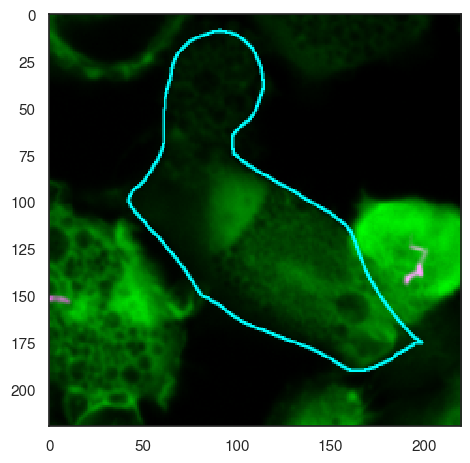

In [551]:
test = tn_glimpse_maker(unique_ID = '433.3.4', df = df, time = 1)
imshow(test)